In [2]:
%matplotlib widget

In [69]:
import glob
import os.path
import numpy as np
from astropy.io import fits

from image_plane_correction.flow import Flow
from image_plane_correction.catalogs import theoretical_sky
from image_plane_correction.preprocessing import normalize, normalize_high, preprocess
from image_plane_correction.util import indices, rescale_quantile, gaussian_filter, circular_mask
from image_plane_correction import data
from image_plane_correction.interactive import plot_flow, plot_image, toggle_images

In [70]:
image_fns = sorted(glob.glob('/lustre/gh/main/10h/2024-12-18/Run_Rescue_20260205_060823/55MHz/snapshots/55MHz*I-image.fits'))
psf_fns = sorted(glob.glob('/lustre/gh/main/10h/2024-12-18/Run_Rescue_20260205_060823/55MHz/snapshots/55MHz*-psf.fits'))

In [71]:
assert len(image_fns) == len(psf_fns)

In [91]:
def calcflow(ind, qa=True, write=False):
    print(f'Processing {os.path.basename(image_fns[ind])}')
    image, imwcs = data.fits_image(image_fns[ind])
    psf, psfwcs = data.fits_image(psf_fns[ind])

    # Calculate model sky, preprocess, and run flow
    sky = theoretical_sky(imwcs, psf, catalog="VLSSR", max_flux=20, path='/home/claw/vlssr_radecpeak.txt')
    image_processed, sky_processed = preprocess(image, sky, weight=1.5)
    flow = Flow.brox(image_processed, sky_processed, alpha=1.3, gamma=150, scale_factor=0.7)
    dewarped = flow.apply(image)

    if qa:
        score = runqa(image, sky, flow, dewarped)
    else:
        score = 1  # pass

    if write:
        if qa and score == 1:
            outname = image_fns[ind].replace('.fits', '_dewarp.fits')
            dewarped_arr = np.array(dewarped)
            fits.writeto(outname, dewarped_arr, imwcs.to_header())
        else:
            print(f'image {image_fns[ind]} failed qa. Not writing dewarped image.')

    return image, sky, flow, dewarped

def runqa(image, sky, flow, dewarped):
    offsets = np.nan_to_num(flow.offsets)
    if not offsets.any():
        print("Warning: All offsets zero")

    shift_mag = np.linalg.norm(offsets, axis=2)
    shift_mean = np.mean(shift_mag)
    shift_5, shift_median, shift_95 = np.percentile(shift_mag, [5, 50, 95])
    print(f"Shift magnitude mean {shift_mean:.1f} pix (5, 50, 95 percentiles: {shift_5:.1f}, {shift_median:.1f}, {shift_95:.1f} pix)")

    if sky is not None:
        pcts = [5, 32, 50, 68, 95]
        residuals = np.abs(np.percentile(dewarped-sky, pcts)) - np.abs(np.percentile(image-sky, pcts))
        if not all(residuals < 0):
            print(f"Not all residuals improved. (Percentile, residual difference): {list(zip(pcts, residuals.tolist()))}")
            score = 0
        else:
            score = 1

    return score

In [92]:
image, sky, flow, dewarped = calcflow(91, write=False, qa=True)

Processing 55MHz-Pilot-Snapshot-20241218_121757-I-image.fits
Shift magnitude mean 5.1 pix (5, 50, 95 percentiles: 0.7, 2.9, 12.1 pix)


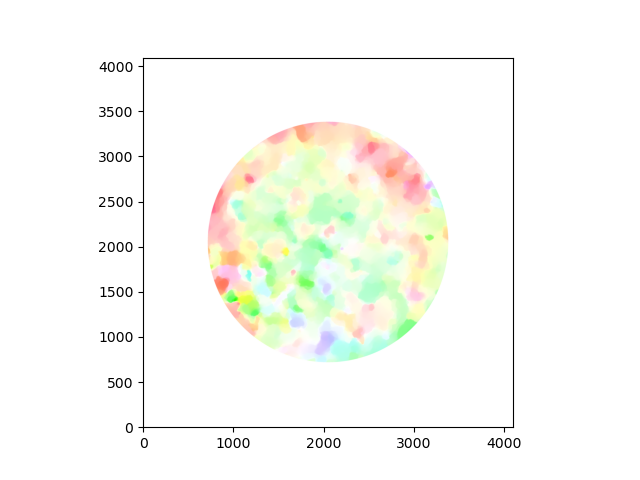

In [93]:
plot_flow(flow, mask=circular_mask(r=0.65))

In [94]:
dewarped = flow.apply(image)

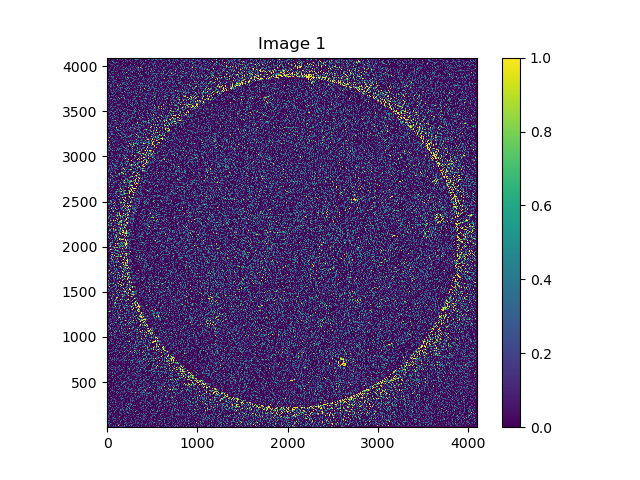

In [95]:
toggle_images(normalize_high(sky-dewarped), normalize_high(sky))